## Filtros de Kalman
Basado en [ref](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06_Multivariate_Kalman_Filters.ipynb)

Un filtro de Kalman es la generalización de los filtros probabilísticos vistos anteriormente cuando las relaciones entre las variables implicadas son lineales.

El principio de funcionamiento es el mismo: 

1. Hacemos una predicción sobre el estado de nuestro sistema en el siguiente estado de tiempo.
1. Combinamos la predicción anterior con la medición que hacemos del estado del sistema para tener una estimación del mismo.

Los filtros de Kalman nos van a permitir además manejar una casuística algo más compleja. Por ejemplo:

1. El estado de nuestro sistema puede contener variables que no son observadas directamente. Por ejemplo, cuando medimos la posición únicamente pero también modelamos la velocidad.
1. Las mediciones que realizamos necesitan transformaciones lineales antes de ser procesadas. Por ejemplo, si para medir una temperatura en realidad lo que medimos es un voltaje a través de una resistencia.
1. Si sabemos que existen dependencias o covarianzas en las distribuciones de probabilidad de las variables las podemos expresar.

Sin más preámbulo, un filtro de Kalman se formula de la siguiente manera:

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(3)\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

En donde:


>- Usamos la notación $x^-$ para indicar que estamos haciendo una predicción de $x$.
>- $\mathbf{P}$ es la incertidumbre (covarianza) de nuestra predicción. 

>- $\mathbf{x}$ es el vector que representa el estado que queremos modelar. 
>- $\mathbf{F}$ es la matriz que usamos para realizar la predicción del estado de nuestro sistema desde un instante de tiempo anterior.

Por ejemplo, $\mathbf{x} =\begin{bmatrix}s \\ v\end{bmatrix}$, en donde $s$ es la posición unidimensional de nuestro sistema y $v$ su velocidad. Nuestra predicción en el siguiente instante de tiempo es que la posición se actualiza de acorde a la velocidad que queda constante. Es decir

$$s^- = s + v$$
$$v^- = v$$


Por lo tanto:

$$
\begin{aligned}
{\begin{bmatrix}s\\v\end{bmatrix}}^- &=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix} \begin{bmatrix}s \\ v\end{bmatrix}
\end{aligned}
$$

Es decir $\mathbf{x}^- = \mathbf{Fx}$, con $\mathbf{F}=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix}$

>- $\mathbf{z}$ es la medida que realizamos.
>- $\mathbf{H}$ es la función de medida, que transforma el estado del sistema en las unidades de medida.
>- $\mathbf{R}$ es el ruido de medida (imprecisión).

Siguiendo con el ejemplo anterior, nuestro estado $\mathbf{x}$ tiene una posición y una velocidad, pero en realidad somo medimos la velocidad ($\mathbf{z}$ es un escalar). Por lo tanto, para comparar la medición con nuestro estado nos fijamos sólo en la posición, La ecuación

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-} \;\;\;(3)$$

mide la diferencia entre la preducción de nuestro modelo y la medición realizada:

$$\textbf{y} = \mathbf{z} - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}s \\v\end{bmatrix}$$

igualmente, como nuestra medida es un escalar (la posición) $\mathbf{R}$ también lo es. Si tuviéramos dos sensores, $\mathbf{z} \in \mathbb{R}^2$ y $\mathbf{R} \in \mathbb{R}^{2\times 2}$

>- $\mathbf{Q}$ es el ruído del proceso. Es decir, la variabilidad con la que nuestro sistema sigue el modelo especificado por $\mathbf{F}$. Por ejemplo, aunque establezcamos todos los elementros de control para que un robot vaya a 10 Km/h, seguramente no mantenga exactamente esa velocidad, por irregularidades en el terreno, en sus motores de tracción, etc. $\mathbf{Q}$ trata de capturar esa variabilidad. La expresión $\mathbf{P^-} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$, únicamente proyecta $\mathbf{P}$ en el espacio de nuestro modelo físico y le añade la variabilidad del mismo ($\mathbf{Q}$).



In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as random
from numpy import dot
import warnings
warnings.filterwarnings('ignore')

class KalmanFilter:

    def __init__(self, dim_x, dim_z, P=0., R=0., Q=None, F=0, H=0, init_x=None, dim_u=0):
        self.x = np.zeros((dim_x, 1)) if init_x is None else init_x # state
        self.P = np.eye(dim_x)*P if np.isscalar(P) else P           # uncertainty covariance
        self.Q = np.eye(dim_x)*Q if np.isscalar(Q) else Q           # process noise
        self.u = np.zeros((dim_u, 1))                               # motion vector
        self.B = 0                           # control transition matrix
        self.F = F                           # state transition matrix
        self.H = H                           # Measurement function
        self.R = np.eye(dim_z)*R             # state uncertainty

        # identity matrix. Do not alter this. 
        self._I = np.eye(dim_x)


    def update(self, Z):

        if Z is None:
            return

        # error (residual) between measurement and prediction
        y = Z - dot(self.H, self.x)

        # project system uncertainty into measurement space 
        S = dot(self.H, self.P).dot(self.H.T) + self.R

        # map system uncertainty into kalman gain
        K = dot(self.P, self.H.T).dot(linalg.inv(S))

        # predict new x with residual scaled by the kalman gain
        self.x += dot(K, y)

        I_KH = self._I - dot(K, self.H)
        self.P = I_KH.dot(self.P) #.dot(I_KH.T) + dot(K, self.R).dot(K.T)


    def predict(self, u=0):
        
        self.x = dot(self.F, self.x) + dot(self.B, u)
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q
        
    def filter_data(self, data):
        count = len(data)
        xhist = [None] * count
        Phist = [None] * count
        
        for t in range(count):            
            z = data[t]
            xhist[t] = np.copy(self.x)
            Phist[t] = np.copy(self.P)
            
            # perform the kalman filter steps
            self.update(z)
            self.predict()

        return xhist, Phist  

## Un filtro de Kalman para medir la posición 1D y estimar la posición y velocidad.

La ganancia de Kalman se usa para combinar la predicción con la medida y:

$$K \propto \frac{incertidumbre_{predicción}}{incertidumbre_{medida}} $$

y también:

- $P$ es el ruido de predicción (más ruido significa más incertidumbre)
- $R$ es el ruido que creemos que tiene la medición
- $Q$ es el ruido del proceso (precisión del robot en mantener su curso)

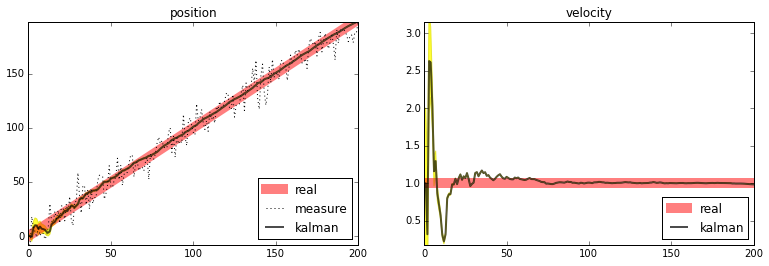

In [14]:
%run -i code/filter.py

def pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P,R,Q):

    init_x = [np.array([estimated_init_pos]), np.array([estimated_init_vel])]

    o = ConstantVelocityRobot(init_pos=robot_pos, vel=robot_vel, mnoise=R)
    o.move_n_time_steps(n=200)
    phist, mhist = o.pos_history, np.array(o.m_history)

    F = np.array([[1, 1], [0, 1]])  # state transition matrix
    H = np.array([[1, 0]])          # Measurement function

    k = KalmanFilter(dim_x=2, dim_z=1, P=P, R=R, Q=Q, F=F, H=H, init_x=init_x)
    xhist, Phist = k.filter_data(mhist)

    xhist = [[i[0][0], i[1][0]] for i in xhist]
    plot_kalman_position_velocity(phist, mhist, xhist, Phist, np.ones(len(xhist))*o.vel )


# prediction, measurement and process noise
P, R, Q                 = 1., 10., 0.

# actual object position and velocity
robot_pos, robot_vel = 0., 1.

# estimated velocity and initial position 
estimated_init_pos, estimated_init_vel      = 0., 1.

pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P, R, Q)


Con un un gran error en la estimación inicial de velocidad y posición ($init\_vel$, $init\_pos$)

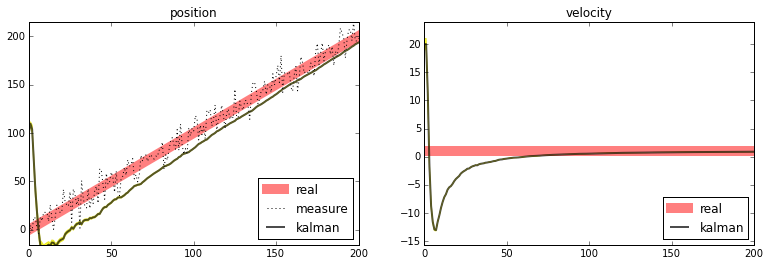

In [15]:
P, R, Q                                = 1., 10., .0
robot_pos, robot_vel                   = 0., 1.
estimated_init_pos, estimated_init_vel = 100., 20.
pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P, R, Q)

Con un pequeño error en la estimación inicial de la velocidad y posición y algo de incertidumbre en el proceso ($Q$)

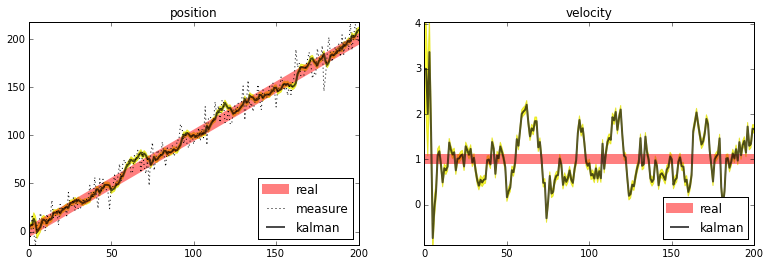

In [16]:
P, R, Q                 = 1., 10., .01
robot_pos, robot_vel = 0., 1.
estimated_init_pos, estimated_init_vel      = 4., 3.
pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P, R, Q)

Con un gran ruido en las mediciones ($R$)

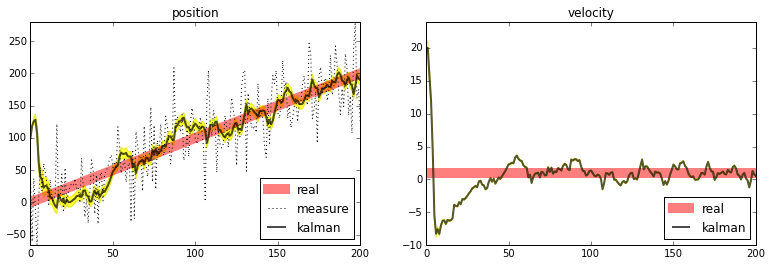

In [24]:
P, R, Q                 = 1., 40., .01
robot_pos, robot_vel = 0., 1.
estimated_init_pos, estimated_init_vel      = 100., 20.
pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P, R, Q)

Igual que antes, pero ahora con un robot de gran precisión ($Q$ muy pequeño)

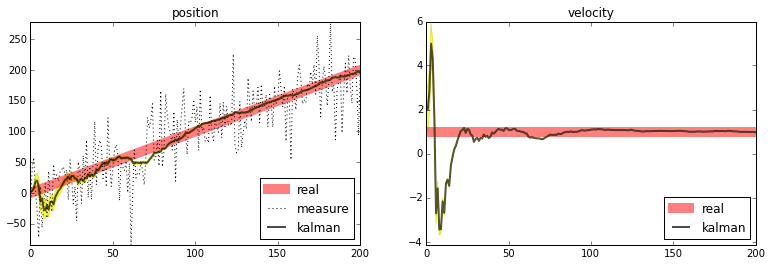

In [23]:
P, R, Q                 = 1., 40., .000001
robot_pos, robot_vel = 0., 1.
estimated_init_pos, estimated_init_vel      = 2., 2.
pos_vel_1D_tracking_example(robot_pos, robot_vel, estimated_init_pos, estimated_init_vel, P, R, Q)